In [2]:
import cv2
import numpy as np
import toml
import os
import msgpack as mp
import msgpack_numpy as mpn
import matplotlib.pyplot as plt
from cv2 import aruco
from tqdm import tqdm
import polars as pl
from pd_support import *

from scipy.spatial.transform import Rotation as R

Loading camera calibration

In [3]:
data = toml.load("../calib_testing.toml")
camera_matrix = np.array(data["calibration"]["camera_matrix"]).reshape(3, 3)
dist_coeff = np.array(data["calibration"]["dist_coeffs"])


_parent_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
_folder_name = "highres_af"
_base_pth = os.path.join(_parent_dir, "recordings", _folder_name)

In [4]:
camera_matrix

array([[1.87037605e+03, 0.00000000e+00, 4.58858429e+02],
       [0.00000000e+00, 1.48574248e+03, 7.67419572e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [5]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

default_ids = [12, 88, 89]

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [6]:
def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs = []
    tvecs = []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            True,
            flags=cv2.SOLVEPNP_IPPE_SQUARE,
        )
        if r is not None and t is not None:
            r = np.array(r).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
            rvecs.append(r)
            tvecs.append(t)
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

In [7]:
rvecs, tvecs = [], []
with open(os.path.join(_base_pth, "webcam_color.msgpack"), "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    for _frame in tqdm(unpacker):
        corners, ids, rejected_img_points = detector.detectMarkers(_frame)
        corners, ids, _, _ = detector.refineDetectedMarkers(
            image=_frame,
            board=board,
            detectedCorners=corners,
            detectedIds=ids,
            rejectedCorners=rejected_img_points,
            cameraMatrix=camera_matrix,
            distCoeffs=dist_coeff,
        )

        if (ids is not None and len(ids) > 0) and all(
            item in default_ids for item in np.array(ids)
        ):
            rotation_vectors, translation_vectors = estimate_pose_single_markers(
                corners=corners,
                marker_size=0.05,
                camera_matrix=camera_matrix,
                distortion_coefficients=dist_coeff,
            )
            rvecs.append(rotation_vectors[0][0])
            tvecs.append(translation_vectors[0][0])

        else:
            rvecs.append(np.array([np.nan, np.nan, np.nan]))
            tvecs.append(np.array([np.nan, np.nan, np.nan]))

timestamp = []
sync = []

with open(os.path.join(_base_pth, "webcam_timestamp.msgpack"), "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    for _p in unpacker:
        sync.append(_p[0])
        timestamp.append(_p[1])


tvecs = np.array(tvecs)
rvecs = np.array(rvecs)
sync = np.array(sync).astype(bool)

1343it [00:35, 37.62it/s]


In [8]:
tvecs

array([[ 0.1057496 , -0.1256444 ,  0.72216493],
       [ 0.1043051 , -0.12493936,  0.71865726],
       [ 0.10418037, -0.1249126 ,  0.71849418],
       ...,
       [ 0.10929077, -0.12539208,  0.72175294],
       [ 0.109166  , -0.12535584,  0.72158241],
       [ 0.10909367, -0.1253922 ,  0.72177595]])

In [9]:
ar_dict = {
    "time": timestamp,
    "sync": sync,
    "x": tvecs[:, 0],
    "y": tvecs[:, 1],
    "z": tvecs[:, 2],
    "rx": rvecs[:, 0],
    "ry": rvecs[:, 1],
    "rz": rvecs[:, 2],
}
ar_df = pl.from_dict(ar_dict)
if type(ar_df["time"][0]) is not datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

In [10]:
pulse_sweep = False
for idx, val in enumerate(ar_df["sync"]):
    if val == True and not pulse_sweep:
        start_pulse = idx
        pulse_sweep = True
    if val == False and pulse_sweep:
        end_pulse = idx
        break
ar_df = ar_df[start_pulse:end_pulse]

In [11]:
mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, f"{_folder_name}"))
mocap_df = add_datetime_col(mocap_df, st_time, "seconds")
mocap_df = pl.from_pandas(mocap_df)

/home/sujith/Documents/programs/notebooks/pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [12]:
tr = get_rb_marker_name(1)
tl = get_rb_marker_name(4)
br = get_rb_marker_name(2)
bl = get_rb_marker_name(5)

In [13]:
_time_diff = ar_df["time"][0] - mocap_df["time"][0]

ar_df = ar_df.with_columns([(pl.col("time") - _time_diff).alias("time")])

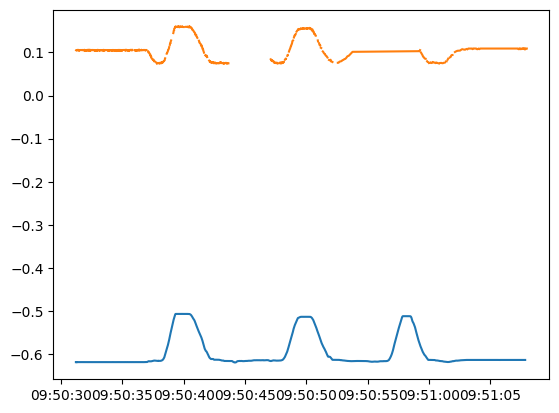

In [14]:
plt.plot(mocap_df["time"], mocap_df[tr["x"]])
plt.plot(ar_df["time"], ar_df["x"])

In [26]:
_frame.shape

(864, 1536)

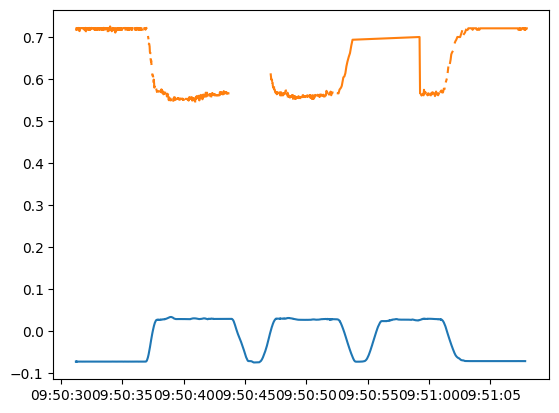

In [16]:
plt.plot(mocap_df["time"], mocap_df[tr["z"]])
plt.plot(ar_df["time"], ar_df["z"])

In [17]:
t_dict = {"x": [], "y": [], "z": []}
rmat = cv2.Rodrigues(ar_df[["rx", "ry", "rz"]][1].to_numpy())[0]

for i in range(len(ar_df["time"])):
    tvec = rmat.T @ (
        ar_df[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
        - ar_df[["x", "y", "z"]][1].to_numpy().reshape(3, 1)
    )
    tvec = tvec.T[0]
    t_dict["x"].append(tvec[0])
    t_dict["y"].append(tvec[1])
    t_dict["z"].append(tvec[2])

In [18]:
tvec

array([nan, nan, nan])

In [19]:
mocap_mean = {"x": [], "y": [], "z": []}
mocap_mean["x"] = mocap_df[[tr["x"], tl["x"], br["x"], bl["x"]]].to_numpy().mean(axis=1)
mocap_mean["y"] = mocap_df[[tr["y"], tl["y"], br["y"], bl["y"]]].to_numpy().mean(axis=1)
mocap_mean["z"] = mocap_df[[tr["z"], tl["z"], br["z"], bl["z"]]].to_numpy().mean(axis=1)

mocap_qt = mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]][0].to_numpy()

mocap_rotation = R.from_quat(mocap_qt).as_matrix()

In [20]:
mocap_mean = pl.from_dict(mocap_mean)

In [21]:
mt_dict = {"x": [], "y": [], "z": []}
rmat_m = mocap_rotation[0]

for i in range(len(mocap_df["time"])):
    tvec_ar = rmat_m.T @ (
        mocap_mean[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
        - mocap_mean[["x", "y", "z"]][0].to_numpy().reshape(3, 1)
    )
    tvec_ar = tvec_ar.T[0]
    mt_dict["x"].append(tvec_ar[0])
    mt_dict["y"].append(tvec_ar[1])
    mt_dict["z"].append(tvec_ar[2])

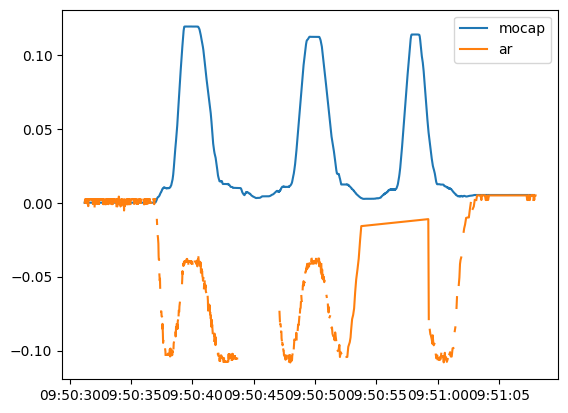

In [22]:
plt.plot(mocap_df["time"], mt_dict["x"], label="mocap")
plt.plot(ar_df["time"], t_dict["x"], label="ar")
plt.legend()

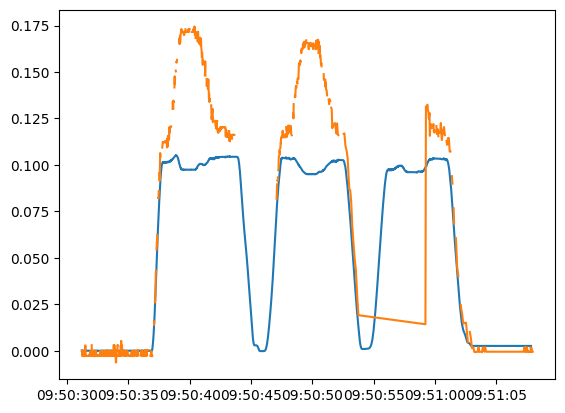

In [23]:
plt.plot(mocap_df["time"], mt_dict["z"])
plt.plot(ar_df["time"], np.array(t_dict["z"]))

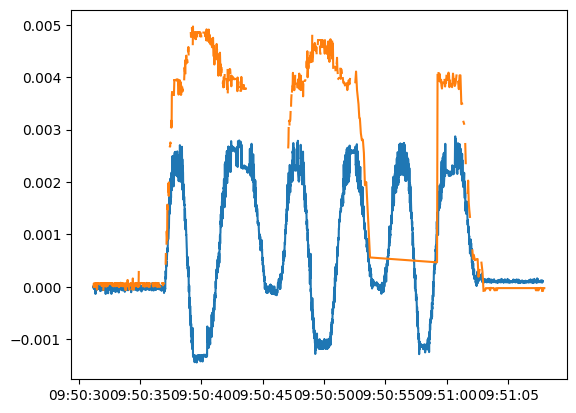

In [24]:
plt.plot(mocap_df["time"], mt_dict["y"])
plt.plot(ar_df["time"], t_dict["y"])